# COMP9517 Project

In [11]:
'''
Please read the readme file first for further practice
'''
import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import skimage
from skimage import morphology
from skimage import measure
import IO_IMAGE
import preprocessing


In [12]:
# draw contours and record properties
def draw_contour(bg,label):
    bg = skimage.color.gray2rgb(bg).copy()
    props = measure.regionprops(label)
    # print the num of cell on the top left
    cv2.putText(bg, f'TOTAL CELL NUM : {len(props)}',(1, 13), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
    for prop in props:
        cv2.rectangle(bg,prop.bbox[:2][::-1],prop.bbox[2:4][::-1],(0,250,0),2)
    return bg

# calulating the overlapping area for bounding boxes
def calc_area(rect1, rect2):
    xl1, yb1, xr1, yt1 = rect1
    xl2, yb2, xr2, yt2 = rect2
    xmin = max(xl1, xl2)
    ymin = max(yb1, yb2)
    xmax = min(xr1, xr2)
    ymax = min(yt1, yt2)
    width = xmax - xmin
    height = ymax - ymin
    if width <= 0 or height <= 0:
        return 0
    cross_square = width * height
    return cross_square

# relabel the overlapped area
def self_check(label):
    pass
    regions =  measure.regionprops(label)
    result=np.zeros((len(regions),len(regions)))
    for m in range(len(regions)):
        for n in range(len(regions)):
            if m == n:
                continue
            bbox1 = regions[m].bbox
            bbox2 = regions[n].bbox
            co_area = calc_area(bbox1,bbox2)
            label1 = regions[m].label
            label2 = regions[n].label
            if label1 == label2 or co_area == 0:
                continue
            smaller = regions[m] if regions[m].bbox_area <= regions[n].bbox_area else regions[n]
            bigger = regions[n] if regions[m].bbox_area <= regions[n].bbox_area else regions[m]
            overlap_rate = co_area/smaller.bbox_area
            if overlap_rate > 0.4:
#                 print(smaller.label,bigger.label)
                label[np.where(label==smaller.label)] = bigger.label


In [13]:
class IMAGE():
    def __init__(self,index,regionprops):
        self.index = index
        self.collection = {}
        self.regionprop = regionprops
        self.count = 0
        self.dividing = 0
        
    def register(self,cell):
        self.collection[cell.id]=cell
        self.count = len(self.collection)
        
    def find_dividing(self,dividing):
        self.dividing = int(dividing)


class CELL():
    def __init__(self,id,prop):
        self.id = id
        self.prop = prop
        self.centroid = prop.centroid
        self.pre_id = -1
        self.speed = 0
        self.tdist = 0
        self.ndist = 0
        self.ratio = 0
        
    def update(self,pre_id):
        self.pre_id = pre_id
    
    def calulate(self,speed,tdist,ndist,ratio):
        self.speed = round(speed,2)
        self.tdist = round(tdist,2)
        self.ndist = round(ndist,2)
        self.ratio = round(ratio,2)
        

def register_image(labeled_img,seq):
    regionprops = measure.regionprops(labeled_img)
    output=IMAGE(seq,regionprops)
    num_cells = len(regionprops)
    for i in range(num_cells):
        prop = regionprops[i]
        cell = CELL(i,prop)
        output.register(cell)
    return output

# A=IMAGE(0)
# a=CELL(1,region1[0])
# b=CELL(2,region1[2])
# A.register(a)
# A.register(b)
# A.collection[1].prop

In [14]:
def eu_distance(x,y):
    return np.sqrt(np.sum(np.square(np.array(x)-np.array(y))))

def product_overlaparea(previous,current):
    result=np.zeros((len(previous),len(current)))
    for m in range(len(previous)):
        for n in range(len(current)):
            co_area = len(np.intersect1d(previous[m].coords,current[n].coords))
            pre_area = previous[m].area
            cur_area = current[n].area
            result[m,n] = 1- co_area*co_area/pre_area/cur_area
    return np.array(result).reshape(len(previous),len(current))

def mapping(attr,iterable):
    return list(map(lambda x: getattr(x, attr) ,iterable))

def get_matching_list(i,flag_dist):      # flag_dist is for choosing the alternative in distance matching 
    pre_region = archive[i-1].regionprop
    cur_region = archive[i].regionprop
    pre_center1ist = mapping('centroid',pre_region)                 # list of coordinate pairs
    cur_center1ist = mapping('centroid',cur_region)
    
    # if sum(pre_center1ist) == 0 or  sum(cur_center1ist) == 0:
        # return np.zeros(len(cur_region))
    
    # distance of centroid      np.mean(np.min(d,axis=1)) = 7.28
#     print(len(pre_center1ist),len(cur_center1ist))
    euclidian_distance = dist.cdist(pre_center1ist,cur_center1ist)      
    
    # the degree of overlap
    overlapping_area = product_overlaparea(pre_region,cur_region)
    
    # for possible division list
    # np.argpartition(euclidian_distance, 3,axis=0)[:3]
    
    E1_1 = np.argpartition(euclidian_distance, 2,axis=0)[:2][0]
    E1_2 = np.argpartition(euclidian_distance, 2,axis=0)[:2][1]
    E2=np.argmin(overlapping_area,axis=0)

    matched_list = []
    for i in range(len(cur_region)):
        if E1_1[i] == E2[i]:
            matched_list.append(E1_1[i])
        elif E1_2[i] == E2[i]:
            matched_list.append(E1_2[i])
        elif euclidian_distance[E1_1[i],i] < flag_dist:
            matched_list.append(E1_1[i])
        else:
            matched_list.append(-1) 
    matched_list=np.array(matched_list)
    return matched_list

In [15]:
# initialize the path
path='D:\\UNSW\\2020T2\\9517\\project\\'
dataset_name_map ={1:path + 'DIC-C2DH-HeLa',2:path + 'Fluo-N2DL-HeLa',3:path + 'PhC-C2DL-PSC'}
seq_name_map ={1:'Sequence 1',2:'Sequence 2',3:'Sequence 3',4:'Sequence 4'}

# parameter
DATASET= 3
SEQ = 1
FLAG_DIST = 80 if DATASET ==1 else 10
STOPLINE = 40

# read the whole dataset
dataset = IO_IMAGE.read_img(dataset_name_map[DATASET])   # choose the target dataset
sequence = dataset[seq_name_map[SEQ]]                # choose the sequence
num_img = len(sequence)


# customized folder name
folder_name = seq_name_map[SEQ].lower() + 'bbox'       
trajectory_folder = seq_name_map[SEQ].lower()+'trajectory'

# initialize
seq_processed_img=[]                               # processed img
seq_labeled_img=[]                                 # labeled img
seq_drawed=[]                                      # img with bounding box
archive = []                                       # for image class
final=[]                                           # img in the final

# main program
for i in range(num_img):
    if i == STOPLINE:
        break
    raw_img = sequence[i]
    if DATASET==2 :
        bg,processed_img = preprocessing.preprocess_set2(raw_img)    # bg is background image for drawing 
        labeled_img = preprocessing.watershed_algorithm(processed_img) # labeled_img is for registration
        self_check(labeled_img)                                        # modify labels
    elif DATASET==1:
        bg,labeled_img = preprocessing.preprocess_set1(raw_img) 
        processed_img = labeled_img
    elif DATASET==3:
        bg,processed_img = preprocessing.preprocess_set3(raw_img)    # bg is background image for drawing 
        labeled_img = preprocessing.watershed_algorithm(processed_img) # labeled_img is for registration
        self_check(labeled_img)                                        # modify labels

    seq_processed_img.append(processed_img)
    cur_img = register_image(labeled_img,i)                        # register the image to class  
    archive.append(cur_img)
    rct_img = draw_contour(bg,labeled_img)                         # draw bounding box  
    seq_drawed.append(rct_img)
    seq_labeled_img.append(labeled_img)
    IO_IMAGE.write_img(rct_img, folder_name,i)                     # write image into file  
    # -------------------------------------------
    if i != 0:                                                     # record corresponding past cell
        num_cells = cur_img.count                                  # the number of cells in current img
        matched_list= get_matching_list(i,FLAG_DIST)                         # list size: current img's num of cells
        for k in range(num_cells):
            if matched_list[k] == -1:
                continue
            else:
                pre_cell_index = matched_list[k]
                cur_cell = cur_img.collection[k]
                cur_cell.update(pre_cell_index)
    # -------------------------------------------
        dividing_list=list(matched_list.copy())                    # for finding the dividing cell( on the previous image)
        for each in np.unique(matched_list):
            dividing_list.remove(each)
        dividing_list=np.unique(dividing_list)
        if -1 in dividing_list:
            dividing_list=list(dividing_list)
            dividing_list.remove(-1)
        pre_img = archive[i-1]
        pre_img.find_dividing(len(dividing_list))
        pre_bg = seq_drawed[i-1]
        for i in range(pre_img.count):
            prop = pre_img.regionprop[i]
            if i in dividing_list:
                cv2.rectangle(pre_bg,prop.bbox[:2][::-1],prop.bbox[2:4][::-1],(255,0,0),2)

In [16]:

# draw lines
for i in range(num_img):
    if i == STOPLINE:
        break
    bg = seq_drawed[i].copy()
    cur_img = archive[i]
    num_cells = cur_img.count
    for k in range(num_cells):
        cur_cell = cur_img.collection[k]
        cur_center = cur_cell.centroid
        pre_cell_index = cur_cell.pre_id
        
        offset = 1
        p_list = [cur_center]
        while pre_cell_index != -1 and offset <= i:
            pre_img = archive[i-offset]
            pre_cell = pre_img.collection[pre_cell_index]
            pre_center = pre_cell.centroid
            p_list.append(pre_center)
            pre_cell_index = pre_cell.pre_id
            offset+=1
        for m in range(len(p_list)-1):
            cv2.line(bg, tuple(map(int,p_list[m]))[::-1],tuple(map(int,p_list[m + 1]))[::-1], (0, 255, 150), 2)
            
        # compute the velocity    
        if len(p_list) > 1:
#             print(f'img {i} cell{k}')
            tdist = 0
            for j in range(len(p_list)-1):
                tempdist = eu_distance(p_list[j],p_list[j+1])
                tdist += tempdist
            speed = eu_distance(p_list[0],p_list[1])
            ndist = eu_distance(p_list[0],p_list[-1])
            ratio = round(tdist/ndist,2) if ndist !=0 else 0
            cur_img.collection[k].calulate(speed,tdist,ndist,ratio)
            
    bg=cv2.putText(bg, f'TOTAL DIVIDING NUM : {cur_img.dividing}',(1, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
    final.append(bg)
    IO_IMAGE.write_img(bg, trajectory_folder,i)

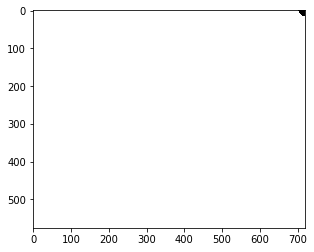

In [9]:
plt.imshow(seq_processed_img[0],'gray')

In [ ]:
########### the followings are functional  ###################

In [ ]:
# UI 

def mouse(event, x, y, flags, param):
    regionprop = param.regionprop
    center1ist = mapping('centroid',regionprop)
    if event == cv2.EVENT_LBUTTONDOWN:
        distance1ist = [ eu_distance(i,(y,x)) for i in center1ist]
        min_dis_index = np.argmin(distance1ist,axis=0) 
        
#         print(min_dis_index,center1ist[0],len(center1ist))
        
        if distance1ist[min_dis_index] < 10:
#             print(min_dis_index,end='')
            speed = 'speed:'+str(param.collection[min_dis_index].speed)
            tdist = 'tdist:'+str(param.collection[min_dis_index].tdist)
            ndist = 'ndist:'+str(param.collection[min_dis_index].ndist)
            ratio = 'ratio:'+str(param.collection[min_dis_index].ratio)
            string1 = ','.join((speed,tdist))
            string2 = ','.join((ndist,ratio))
            cv2.putText(img, string1, (x, y), cv2.FONT_HERSHEY_SIMPLEX,0.5, (238,229, 0), thickness = 1)
            cv2.putText(img, string2, (x, y-13), cv2.FONT_HERSHEY_SIMPLEX,0.5, (238 ,229 ,0), thickness = 1)
            cv2.imshow("image", img)
            
for i in range(STOPLINE):
    target= i
    img = final[target].copy()
    param = archive[target]
    cv2.imshow("image", img)
    cv2.setMouseCallback("image", mouse,param)
    cv2.waitKey(4000)
cv2.destroyAllWindows()

In [ ]:
# archive[0].collection[1].prop.centroid

(<matplotlib.axes._subplots.AxesSubplot at 0x1d99a182348>,
 <matplotlib.image.AxesImage at 0x1d99a74ee88>)

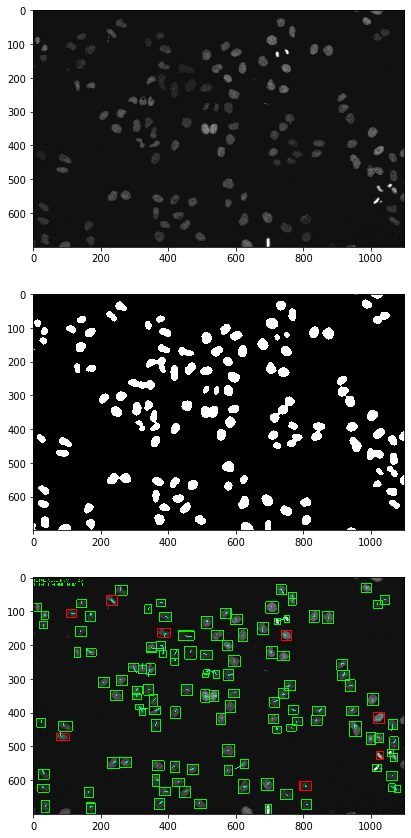

In [8]:
# show pic
def normalize(input_img):
    return ((input_img - input_img.min()) / (input_img.max() - input_img.min()) * 255).astype(np.uint8)

i = 2
raw = sequence[i]
pi=seq_processed_img[i]
res= final[i]
fig, ax = plt.subplots(figsize=(20,20))
plt.subplot(411),plt.imshow(normalize(raw),'gray')
plt.subplot(412),plt.imshow(pi,'gray')
plt.subplot(413),plt.imshow(res,'gray')